In [1]:
import sys

sys.path.append('..')

%load_ext autoreload
%autoreload 2

In [2]:
import utils.coco_generator as coco
import utils.doors_generator as doors
import utils.imagenet_generator as imagenet

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras.backend as K
import models.siamese
import models.siamese_average_representation
import models.siamese_concat
import keras
import time
import cv2

%matplotlib inline

/scratch/home/aelphy/py27/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
BATCH_SIZE = 25

# Build model from scratch

In [4]:
model = models.siamese_concat.build(
    (256, 256, 3), 1024, 128, 'vgg16'
)

# NOTE: doesn't work with keras
# model.compile(
#     loss=lambda y, x: tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=x)),
#     optimizer=keras.optimizers.RMSprop(1e-5),
#     metrics=[]
# )

labels = tf.placeholder(tf.float32, name='labels')

loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

global_step = tf.Variable(0, trainable=False)
train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
tf.add_to_collection('train_step', train_step)

sess = tf.Session()
sess.run(tf.global_variables_initializer())

input_1 = model.input[0]
input_2 = model.input[1]

# Write graph

In [5]:
graph_writer = tf.summary.FileWriter('../logs/', graph=tf.get_default_graph())
summary_writer = tf.summary.FileWriter('../logs/')
tf.summary.scalar('loss', loss)
merged = tf.summary.merge_all()

# Pretrain model

In [6]:
# Imagenet
imagenet_headers = imagenet.load_headers_by_categories()
minibatch_generator = imagenet.MinibatchGenerator(imagenet_headers, BATCH_SIZE, 256, 256, positive='class').run()

# Coco
# coco_headers = coco.load_headers_by_categories()
# minibatch_generator = coco.MinibatchGenerator(coco_headers, BATCH_SIZE, 256, 256, positive='class').run()

In [ ]:
#train iter
for i in range(1000000):
    try:
        b_l, b_r, b_sim = minibatch_generator.next()

        _, l, summary = sess.run([train_step, loss, merged],
            feed_dict={input_1:b_l*255, input_2:b_r*255, labels: b_sim})
    except:
        imagenet_headers = imagenet.load_headers_by_categories()
        minibatch_generator = imagenet.MinibatchGenerator(imagenet_headers, BATCH_SIZE, 256, 256, positive='class').run()
        
        b_l, b_r, b_sim = minibatch_generator.next()
        
        _, l, summary = sess.run([train_step, loss, merged],
            feed_dict={input_1:b_l*255, input_2:b_r*255, labels: b_sim})
        
    summary_writer.add_summary(summary, i)

    if i % 100 == 0:
        print "\r#%d - Loss"%i, l
        
# for epoch in range(100):
#     x1, x2, y = minibatch_generator.next()
#     loss = model.train_on_batch([x1, x2], y)
#     print(loss)

#0 - Loss 0.863188
#100 - Loss 0.7271802
#7000 - Loss 0.7168849
#7100 - Loss 0.49560633
#7200 - Loss 0.5982787
#7300 - Loss 0.49961594
#7400 - Loss 0.64128554
#7500 - Loss 0.6147998
#7600 - Loss 0.6509192
#7700 - Loss 0.5257412
#7800 - Loss 0.7282175
#7900 - Loss 0.63313305
#8000 - Loss 0.634821
#8100 - Loss 0.5485617
#8200 - Loss 0.6876649
#8300 - Loss 0.5242201
#8400 - Loss 0.5749893
#8500 - Loss 0.6225183
#8600 - Loss 0.6646666
#8700 - Loss 0.6446774
#8800 - Loss 0.5123434
#8900 - Loss 0.70527834
#9000 - Loss 0.5846563
#9100 - Loss 0.5387679
#9200 - Loss 0.6905695
#9300 - Loss 0.5331321
#9400 - Loss 0.8089714
#9500 - Loss 0.61752653
#9600 - Loss 0.6602434
#9700 - Loss 0.6332886
#9800 - Loss 0.6533036
#9900 - Loss 0.712222
#10000 - Loss 0.61025727
#10100 - Loss 0.5820503
#10200 - Loss 0.51238763
#10300 - Loss 0.5735281
#10400 - Loss 0.6771289
#10500 - Loss 0.67766714
#10600 - Loss 0.57298297
#10700 - Loss 0.5851602
#10800 - Loss 0.5606778
#10900 - Loss 0.75883365
#11000 - Loss 0.5084

# Save pretrained weights

In [9]:
vars = []
for i, var in enumerate(tf.trainable_variables()):
    vars.append(sess.run(var))

In [17]:
np.savez('../weights/siamese_concat_pretrained_imagenet.npz', vars)

# Load pretrained weights

In [17]:
with np.load('../weights/siamese_concat_pretrained_imagenet.npz') as f:
    param_values = [f['arr_%d' % i] for i in range(len(f.files))][0]

In [22]:
def reset_model_to_pretrained_state():
    tf.reset_default_graph()
    global model
    global input1
    global input2
    global sess
    global train_step
    global loss
    global labels
    
    model = models.siamese_concat.build(
        (256, 256, 3), 1024, 128, 'vgg16'
    )

    labels = tf.placeholder(tf.float32, name='labels')

    loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=labels, logits=model.output))

    global_step = tf.Variable(0, trainable=False)
    train_step = tf.train.RMSPropOptimizer(1e-5).minimize(loss, global_step=global_step)
    tf.add_to_collection('train_step', train_step)

    sess = tf.Session()
    sess.run(tf.global_variables_initializer())

    input_1 = model.input[0]
    input_2 = model.input[1]
    
    for i, var in enumerate(tf.trainable_variables()):
        sess.run(var.assign(param_values[i]))

# Load doors

In [11]:
HAND_CRAFTED_PATH = '/scratch/home/aelphy/projects/guardian/data/doors_from_web/'
HAND_CRAFTED_ANNOTATION_PATH = '/scratch/home/aelphy/projects/guardian/data/hand_crafted_doors.txt'

In [12]:
Xc, Xd, y, wpc = doors.load_data()

/scratch/home/aelphy/projects/guardian/data/doors/
/scratch/home/aelphy/projects/guardian/data/doors/
/scratch/home/aelphy/projects/guardian/data/doors/
/scratch/home/aelphy/projects/guardian/data/doors/
/scratch/home/aelphy/projects/guardian/data/doors/
/scratch/home/aelphy/projects/guardian/data/doors/
/scratch/home/aelphy/projects/guardian/data/doors/
/scratch/home/aelphy/projects/guardian/data/doors/


# Annotation

In [13]:
import os
import ipywidgets

In [14]:
# with open(HAND_CRAFTED_ANNOTATION_PATH, 'wb') as f:
#     for fname in os.listdir(HAND_CRAFTED_PATH):
#         im = plt.imread(os.path.join(hand_crafted_path, fname))
#         plt.imshow(im)
#         plt.show()
#         f.write('{}, {}\n'.format(fname, input()))

# Evaluation

In [28]:
sigmoid = lambda x: 1 / (1 + np.exp(-x))

def predict(model, inputs):
    return sigmoid(sess.run(model.output, feed_dict={model.input[0] : inputs[0]*255, model.input[1] : inputs[1]*255}))

def do_test(test_img, label):
    tets_metric1 = 0
    for batch in doors.test_iterate_minibatches(test_img, paired_doors_generator_object.closed_reference_doors, BATCH_SIZE):
        tets_metric1 += predict(model, batch).sum()
    mean1 = tets_metric1 / len(paired_doors_generator_object.closed_reference_doors)
    
    tets_metric2 = 0
    for batch in doors.test_iterate_minibatches(test_img, paired_doors_generator_object.open_reference_doors, BATCH_SIZE):
        tets_metric2 += predict(model, batch).sum()
    mean2 = tets_metric2 / len(paired_doors_generator_object.open_reference_doors)
    
    answer = np.argmin([mean1, mean2])
    
    return answer == label, (mean1, mean2), test_img

In [29]:
scores = []

for test_wp in set(wpc[0]):
    Xc_open = Xc[(y==1) & (wpc[0]!=test_wp)]
    Xc_closed = Xc[(y==0) & (wpc[0]!=test_wp)]
    doors_generator = doors.MinibatchGenerator(Xc_open, Xc_closed, BATCH_SIZE).run()

    Xc_open_test = Xc[(y==1) & (wpc[0]==test_wp)]
    Xc_closed_test = Xc[(y==0) & (wpc[0]==test_wp)]

    paired_doors_generator_object = doors.PairMinibatchGenerator(Xc_open, Xc_closed, HAND_CRAFTED_PATH, HAND_CRAFTED_ANNOTATION_PATH, BATCH_SIZE)
    paired_doors_generator = paired_doors_generator_object.run()

    reset_model_to_pretrained_state()

    for i in range(500):
        b_l, b_r, b_sim = paired_doors_generator.next()

        _, l = sess.run(
            [train_step, loss],
            feed_dict={model.inputs[0]: b_l * 255, model.inputs[1]: b_r * 255, labels: b_sim}
        )

        if i % 100 == 0:
            print "\r#%d - Loss"%i, l

    for im in Xc_closed_test:
        scores.append(do_test(im, 0))

    for im in Xc_open_test:
        scores.append(do_test(im, 1))

#0 - Loss 1.0618414
#100 - Loss 0.66580594
#200 - Loss 0.40934244
#300 - Loss 0.0034842838
#400 - Loss 0.0021318153
#0 - Loss 0.9838486
#100 - Loss 0.6159354
#200 - Loss 0.37748194
#300 - Loss 0.012731429
#400 - Loss 0.22838508
#0 - Loss 0.92731357
#100 - Loss 0.59684867
#200 - Loss 0.13066877
#300 - Loss 0.015357267
#400 - Loss 0.004972724
#0 - Loss 1.0157825
#100 - Loss 0.6314631
#200 - Loss 0.46458092
#300 - Loss 0.010144239
#400 - Loss 0.0019259349
#0 - Loss 0.8896691
#100 - Loss 0.71722525
#200 - Loss 0.122432746
#300 - Loss 0.006894614
#400 - Loss 0.0013638654
#0 - Loss 0.9133427
#100 - Loss 0.70769817
#200 - Loss 0.6741192
#300 - Loss 0.038819626
#400 - Loss 0.015674235
#0 - Loss 0.8647542
#100 - Loss 0.6281824
#200 - Loss 0.21385431
#300 - Loss 0.014256652
#400 - Loss 0.0049365642
#0 - Loss 0.9352754
#100 - Loss 0.6666305
#200 - Loss 0.23992193
#300 - Loss 0.057385992
#400 - Loss 0.0028438668
#0 - Loss 0.92313987
#100 - Loss 0.71128446
#200 - Loss 0.3090857
#300 - Loss 0.013614

In [30]:
print(1)

1


In [26]:
def iterate_minibatches(inputs, batchsize, shuffle=False):
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt]

In [27]:
reprs_open = []

for batch in iterate_minibatches(paired_doors_generator_object.open_reference_doors, BATCH_SIZE):
    reprs_open.append(sess.run(model.layers[3].input[0], feed_dict={model.inputs[0]: np.asarray(batch) * 255}))
    
for batch in iterate_minibatches(paired_doors_generator_object.open_doors, BATCH_SIZE):
    reprs_open.append(sess.run(model.layers[3].input[0], feed_dict={model.inputs[0]: np.asarray(batch) * 255}))

In [33]:
open_avg = np.concatenate(reprs_open).mean(axis=0)

In [35]:
reprs_closed = []

for batch in iterate_minibatches(paired_doors_generator_object.closed_reference_doors, BATCH_SIZE):
    reprs_closed.append(sess.run(model.layers[3].input[0], feed_dict={model.inputs[0]: np.asarray(batch) * 255}))
    
for batch in iterate_minibatches(paired_doors_generator_object.closed_doors, BATCH_SIZE):
    reprs_closed.append(sess.run(model.layers[3].input[0], feed_dict={model.inputs[0]: np.asarray(batch) * 255}))

In [36]:
closed_avg = np.concatenate(reprs_closed).mean(axis=0)

In [47]:
tf.reset_default_graph()
model = models.siamese_average_representation.build((256, 256, 3), 1024, 128, 'vgg16')

In [42]:
model = models.siamese_average_representation.build((256, 256, 3), 1024, 128, 'vgg16')

In [54]:
sess = tf.Session()

In [58]:
sess.run(tf.global_variables_initializer())

In [59]:
reset_model_to_pretrained_state()

In [68]:
sigmoid(sess.run(
    model.output,
    feed_dict={model.input[0]: Xc_closed_test * 255, model.input[1]: open_avg.reshape(1, 1, 256)}
))

array([[[0.26106897],
        [0.26397592],
        [0.25000793],
        [0.27712402],
        [0.26898405],
        [0.26680505],
        [0.26366174],
        [0.2624163 ],
        [0.2612465 ],
        [0.2656877 ],
        [0.25853032],
        [0.26715893],
        [0.26119387],
        [0.2633819 ],
        [0.26454753],
        [0.26647717],
        [0.26609442],
        [0.26491216],
        [0.2625945 ],
        [0.26242492],
        [0.26524034],
        [0.26659495],
        [0.26107398],
        [0.2627166 ],
        [0.26116598],
        [0.26533392],
        [0.26799348],
        [0.2576738 ],
        [0.25728083],
        [0.257873  ],
        [0.25636595],
        [0.25979286],
        [0.25756827],
        [0.2588986 ],
        [0.25466603],
        [0.25599012],
        [0.25558838],
        [0.25705913],
        [0.25535834],
        [0.2608021 ],
        [0.25992417],
        [0.25648218],
        [0.26001057],
        [0.2604958 ],
        [0.2624236 ],
        [0

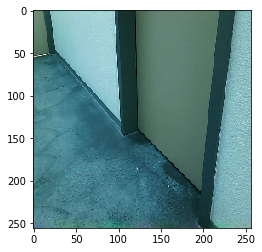

In [76]:
plt.imshow(Xc_closed_test[0])

In [69]:
sigmoid(sess.run(
    model.output,
    feed_dict={model.input[0]: Xc_closed_test * 255, model.input[1]: closed_avg.reshape(1, 1, 256)}
))

array([[[0.581319  ],
        [0.58269596],
        [0.5738388 ],
        [0.5825554 ],
        [0.59082395],
        [0.579218  ],
        [0.57839316],
        [0.5750222 ],
        [0.59389395],
        [0.6016738 ],
        [0.5994501 ],
        [0.6005603 ],
        [0.59828925],
        [0.60067254],
        [0.60149664],
        [0.605218  ],
        [0.6010484 ],
        [0.6009558 ],
        [0.5988782 ],
        [0.5986376 ],
        [0.599921  ],
        [0.6055623 ],
        [0.59275085],
        [0.60027844],
        [0.5974267 ],
        [0.60293347],
        [0.60083413],
        [0.5934924 ],
        [0.5939359 ],
        [0.5948599 ],
        [0.59365803],
        [0.5962835 ],
        [0.5953097 ],
        [0.5997254 ],
        [0.5933006 ],
        [0.5930059 ],
        [0.5966304 ],
        [0.5973486 ],
        [0.5938587 ],
        [0.6026743 ],
        [0.5985941 ],
        [0.5950414 ],
        [0.5981626 ],
        [0.59968823],
        [0.5962344 ],
        [0

In [74]:
sigmoid(sess.run(
    model.output,
    feed_dict={model.input[0]: Xc_open_test * 255, model.input[1]: open_avg.reshape(1, 1, 256)}
))

array([[[0.25598246],
        [0.25549248],
        [0.25576422],
        [0.24502628],
        [0.24556608],
        [0.2686596 ],
        [0.25391808],
        [0.2740675 ],
        [0.26862046],
        [0.2782985 ],
        [0.26886925],
        [0.27491066],
        [0.27582827],
        [0.2772852 ],
        [0.27705616],
        [0.26714674]]], dtype=float32)

In [73]:
sigmoid(sess.run(
    model.output,
    feed_dict={model.input[0]: Xc_open_test * 255, model.input[1]: closed_avg.reshape(1, 1, 256)}
))

array([[[0.5730384 ],
        [0.57146627],
        [0.57002825],
        [0.55886674],
        [0.56142235],
        [0.5694151 ],
        [0.5699698 ],
        [0.592233  ],
        [0.5829376 ],
        [0.58756334],
        [0.60246456],
        [0.5933899 ],
        [0.59249353],
        [0.58303905],
        [0.5746054 ],
        [0.5734044 ]]], dtype=float32)

In [76]:
np.abs((open_avg - reprs_open[0])).sum()

12787.253

In [66]:
np.abs((open_avg - closed_avg)).sum()

344.22418

In [78]:
np.abs((closed_avg - reprs_closed[1])).sum()

11060.307

In [83]:
models.siamese_average_representation

AttributeError: 'module' object has no attribute 'siamese_average_representation'

AttributeError: 'Tensor' object has no attribute 'output_shape'

In [50]:
import cv2

In [59]:
x_input1 = cv2.resize(plt.imread('../data/2018-02-18 23.51.20.jpg'), (256, 256)).reshape(1, 256, 256, 3)

In [60]:
do_test(x_input1, 1)

(True, (17.361095852322048, 7.74400322084131e-09), array([[[[ 48,  39,  30],
          [ 53,  44,  35],
          [ 61,  51,  41],
          ...,
          [233, 170,  99],
          [239, 176, 105],
          [241, 179, 106]],
 
         [[ 24,  17,   9],
          [ 24,  15,   6],
          [ 58,  49,  40],
          ...,
          [239, 176, 105],
          [240, 177, 106],
          [223, 161,  88]],
 
         [[ 20,  14,   8],
          [ 24,  17,   9],
          [ 34,  25,  16],
          ...,
          [233, 170,  99],
          [245, 182, 111],
          [226, 164,  91]],
 
         ...,
 
         [[ 58,  58,  55],
          [ 62,  63,  58],
          [ 60,  61,  55],
          ...,
          [ 21,  16,  12],
          [ 26,  17,   8],
          [ 53,  40,  29]],
 
         [[ 60,  62,  57],
          [ 62,  63,  57],
          [ 67,  64,  59],
          ...,
          [ 15,  11,   8],
          [ 13,  12,   8],
          [ 14,  15,  10]],
 
         [[ 71,  74,  67],
       

In [26]:
total = 0

for s in scores:
    total += s[0]

In [27]:
total / float(len(scores))

0.7658823529411765

In [31]:
total = 0

for s in scores:
    total += s[0]
    
total / float(len(scores))

0.7835294117647059

In [24]:
import pickle

In [25]:
with open('../weights/scores', 'wb') as f:
    pickle.dump(scores, f)

In [46]:
for s in scores:
    print s[0], s[1]
    if not(s[0]):
        plt.imshow(s[2])
        plt.show()

True (1.1709549428849818e-06, 5.815789222717285)
True (8.867338210125395e-07, 5.815789473684211)
True (1.2655365610859793e-06, 5.815789473684211)
True (2.4128282395273636e-06, 5.815789473684211)
True (5.270208940613388e-07, 5.815789473684211)
True (2.2782874460336444e-06, 5.815789473684211)
True (1.5596456211457937e-06, 5.815789423490825)
True (4.631617887440598e-06, 5.815789423490825)
True (6.43774140471651e-07, 5.815789473684211)
True (6.45198140013391e-07, 5.815789473684211)
True (3.6265084312080296e-07, 5.815789473684211)
True (6.780882898261656e-07, 5.815789473684211)
True (1.7676102100411878e-06, 5.815789473684211)
True (7.554011085788817e-07, 5.815789473684211)
True (3.9915180979282424e-07, 5.815789473684211)
True (6.321522601932897e-07, 5.815789473684211)
True (6.853068329636269e-07, 5.815789473684211)
True (4.306949701550643e-07, 5.815789473684211)
True (1.3489594852009488e-06, 5.815789473684211)
True (2.303318109575514e-07, 5.815789473684211)
True (2.1523881483613097e-07, 5.8